# **Imports and installations**

In [102]:
!pip install renderlab


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
# https://github.com/ryanrudes/renderlab
import renderlab as rl # to render them

In [104]:
!pip install gymnasium


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
import gymnasium as gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import matplotlib.pyplot as plt
import random


# **Models**

## **Deep Q Network**

In [106]:
class DeepQNetwork(nn.Module):
  def __init__(self, lr, n_action, input_dims):
    super(DeepQNetwork, self).__init__()

    self.layer1 = nn.Linear(*input_dims, 128)
    self.layer2 = nn.Linear(128, 256)
    self.layer3 = nn.Linear(256, 128)
    self.layer4 = nn.Linear(128, 64)
    self.layer5 = nn.Linear(64, n_action)

    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()

  def forward(self, state):
    layer1 = F.relu(self.layer1(state))
    layer2 = F.relu(self.layer2(layer1))
    layer3 = F.relu(self.layer3(layer2))
    layer4 = F.relu(self.layer4(layer3))
    actions = self.layer5(layer4)
    return actions


## **Deep Q-Learning**

In [107]:
class Deep_Q_learning_Agent():
  def __init__(self, input_dims, n_actions, learning_rate, gamma=0.99,
                epsilon=1.0, eps_dec=1e-5, eps_min=0.01):
    self.learning_rate = learning_rate
    self.input_dims = input_dims
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min

    self.Q = DeepQNetwork(self.learning_rate, self.n_actions, self.input_dims)

  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
        state = T.tensor(observation, dtype=T.float)
        actions = self.Q.forward(state)
        action = T.argmax(actions).item()
    else:
        action = np.random.choice(self.n_actions)

    return action

  def decrement_epsilon(self):
    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

  def learn(self, state, action, reward, next_state):
    self.Q.optimizer.zero_grad()
    states = T.tensor(state, dtype=T.float)
    actions = T.tensor(action)
    rewards = T.tensor(reward)
    next_state = T.tensor(next_state, dtype=T.float)

    q_pred = self.Q.forward(states)[actions]

    q_next = self.Q.forward(next_state).max()

    q_target = rewards + self.gamma*q_next

    loss = self.Q.loss(q_target, q_pred)
    loss.backward()
    self.Q.optimizer.step()
    self.decrement_epsilon()


## **Double Deep Q-Learning**

In [108]:
class DDQ_learning_Agent():
  def __init__(self, input_dims, n_actions, learning_rate, gamma=0.99,
                epsilon=1.0, eps_dec=1e-5, eps_min=0.01):
    self.learning_rate = learning_rate
    self.input_dims = input_dims
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min

    self.Q_next = DeepQNetwork(self.learning_rate, self.n_actions, self.input_dims)
    self.Q_eval = DeepQNetwork(self.learning_rate, self.n_actions, self.input_dims)

  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
        state = T.tensor(observation, dtype=T.float)
        actions = self.Q_eval.forward(state)
        action = T.argmax(actions).item()
    else:
        action = np.random.choice(self.n_actions)

    return action

  def replace_Q_eval_network(self):
    self.Q_eval, self.Q_next = self.Q_next, self.Q_eval

  def decrement_epsilon(self):
    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

  def learn(self, state, action, reward, next_state):
    self.replace_Q_eval_network()
    self.Q_eval.optimizer.zero_grad()
    states = T.tensor(state, dtype=T.float)
    actions = T.tensor(action)
    rewards = T.tensor(reward)
    next_state = T.tensor(next_state, dtype=T.float)

    q_pred = self.Q_eval.forward(states)[actions]
    q_next = self.Q_next.forward(next_state).max()
    q_eval = self.Q_eval.forward(next_state)

    q_target = rewards + self.gamma*q_next
    loss = self.Q_eval.loss(q_target, q_pred)

    loss.backward()
    self.Q_eval.optimizer.step()
    self.decrement_epsilon()


## **Replay Buffer**

In [109]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_counter = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, next_state, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_counter += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_state = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, next_state, terminal

## **Deep Q-Learning in baches**

In [110]:
class Deep_Q_learning_Bach_Agent():
  def __init__(self, input_dims, n_actions, learning_rate, gamma=0.99,
                epsilon=1.0, eps_dec=1e-5, eps_min=0.01, batch_size=32, mem_size=1000):
    self.learning_rate = learning_rate
    self.input_dims = input_dims
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min
    self.batch_size = batch_size
    self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

    self.Q = DeepQNetwork(self.learning_rate, self.n_actions, self.input_dims)

  def store_transition(self, state, action, reward, state_, done):
      self.memory.store_transition(state, action, reward, state_, done)

  def sample_memory(self):
      state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

      # states = T.tensor(state)
      states = T.tensor(state, dtype=T.float)
      rewards = T.tensor(reward)
      dones = T.tensor(done)
      actions = T.tensor(action)
      states_ = T.tensor(new_state, dtype=T.float)
      # states_ = T.tensor(new_state)

      return states, actions, rewards, states_, dones

  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
        state = T.tensor(observation, dtype=T.float)
        actions = self.Q.forward(state)
        action = T.argmax(actions).item()
    else:
        action = np.random.choice(self.n_actions)

    return action

  def decrement_epsilon(self):
    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

  def learn(self):

    if self.memory.mem_counter < self.batch_size:
        return


    states, actions, rewards, next_states, dones = self.sample_memory()
    indices = np.arange(self.batch_size)

    self.Q.optimizer.zero_grad()

    q_pred = self.Q.forward(states)[indices, actions]

    q_next = self.Q.forward(next_states).max(dim=1)[0]
    q_next[dones] = 0.0

    q_target = rewards + self.gamma*q_next

    loss = self.Q.loss(q_target, q_pred)
    loss.backward()
    self.Q.optimizer.step()
    self.decrement_epsilon()


## **Double Deep Q-Learning in baches**

In [111]:
class DDQ_learning_batch_Agent():
  def __init__(self, input_dims, n_actions, learning_rate, gamma=0.99,
                epsilon=1.0, eps_dec=1e-5, eps_min=0.01, batch_size=32, mem_size=1000):
    self.learning_rate = learning_rate
    self.input_dims = input_dims
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min
    self.batch_size = batch_size
    self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

    self.Q_next = DeepQNetwork(self.learning_rate, self.n_actions, self.input_dims)
    self.Q_eval = DeepQNetwork(self.learning_rate, self.n_actions, self.input_dims)

  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
        state = T.tensor(observation, dtype=T.float)
        actions = self.Q_eval.forward(state)
        action = T.argmax(actions).item()
    else:
        action = np.random.choice(self.n_actions)

    return action

  def store_transition(self, state, action, reward, next_state, done):
      self.memory.store_transition(state, action, reward, next_state, done)

  def sample_memory(self):
      state, action, reward, next_state, done = self.memory.sample_buffer(self.batch_size)

      states = T.tensor(state, dtype=T.float)
      rewards = T.tensor(reward)
      dones = T.tensor(done)
      actions = T.tensor(action)
      next_state = T.tensor(next_state, dtype=T.float)

      return states, actions, rewards, next_state, dones

  def replace_Q_eval_network(self):
    self.Q_eval, self.Q_next = self.Q_next, self.Q_eval

  def decrement_epsilon(self):
    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

  def learn(self):
    if self.memory.mem_counter < self.batch_size:
        return

    self.replace_Q_eval_network()
    self.Q_eval.optimizer.zero_grad()

    states, actions, rewards, next_state, dones = self.sample_memory()
    indices = np.arange(self.batch_size)

    q_pred = self.Q_eval.forward(states)[indices, actions]
    q_next = self.Q_next.forward(next_state)
    q_eval = self.Q_eval.forward(next_state)

    max_actions = T.argmax(q_eval, dim=1)
    q_next[dones] = 0.0

    q_target = rewards + self.gamma*q_next[indices, max_actions]
    loss = self.Q_eval.loss(q_target, q_pred)

    loss.backward()
    self.Q_eval.optimizer.step()
    self.decrement_epsilon()


## **Tiling**

In [112]:
class Tiling:

  def __init__(self, env, bins, num_of_tiles):
    self.bins = bins
    self.num_of_tiles = num_of_tiles
    self.tilings = self.create_tilings(env, bins, num_of_tiles)

  def create_tilings(self, env, bins, num_of_tiles):
    low = env.observation_space.low
    high = env.observation_space.high
    displacement = np.arange(1, len(bins)+1)
    tilings = []
    for i in range(num_of_tiles):
        tiling = []
        low_i = low - random.random() * 0.3 * low
        high_i = high + random.random() * 0.3 * high
        segments_size = (high_i - low_i) / bins
        displacement_i = displacement * i % num_of_tiles
        displacement_i = displacement_i * segments_size
        low_i = low_i + displacement_i
        high_i = high_i + displacement_i
        tiling = [np.linspace(i,j,k-1) for i, j, k in zip(low_i, high_i, bins)]
        tilings.append(tiling)
    return tilings

  def get_tiling_ids(self, observation):
    tiling_ids = []
    for tiling in self.tilings:
        current_tiling = []
        for i in range(len(tiling)):
            current_tiling.append(np.digitize(observation[i], tiling[i]))
        tiling_ids.append(current_tiling)
    return tiling_ids

## **Expected Sarsa**

In [113]:
class Expected_Sarsa_Agent():
  def __init__(self, env, get_actions_fn, update_weight_fn, learning_rate, gamma=0.99,
                epsilon=1.0, eps_dec=1e-5, eps_min=0.01, bins=(5), num_of_tilings=4):
    if len(bins) != env.observation_space.shape[0]:
      raise ValueError("the bins value should match the shape of the observation space in the environment")
    self.learning_rate = learning_rate
    self.num_of_actions = env.action_space.n
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min
    self.get_actions = get_actions_fn
    self.update_weight = update_weight_fn
    self.num_of_tilings = num_of_tilings
    self.tiling_object = Tiling(env, bins, num_of_tilings)
    self.weights = np.random.uniform(-0.001, 0.001, (num_of_tilings, *bins, env.action_space.n))

  def choose_action(self, observation):
    if np.random.rand() < self.epsilon:
      return np.random.choice(self.num_of_actions)
    else:
      observation_state_tiling_ids = self.tiling_object.get_tiling_ids(observation)
      action_values = []
      for i, state_tiling_id in enumerate(observation_state_tiling_ids):
          action_values.append(self.get_actions(self.weights[i], state_tiling_id))
      action_values = np.mean(action_values, axis=0)
      return np.random.choice(np.flatnonzero(action_values == action_values.max()))


  def decrement_epsilon(self):
    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min


  def learn(self, state, action, reward, next_state):
    state_ids = self.tiling_object.get_tiling_ids(state)
    next_state_ids = self.tiling_object.get_tiling_ids(next_state)
    for i in range(self.num_of_tilings):
      next_state = next_state_ids[i]
      state = state_ids[i]
      expected_value = 0
      Q_s_prime = self.get_actions(self.weights[i], next_state)

      expected_value = np.sum(Q_s_prime * self.epsilon / Q_s_prime.size) + (1 - self.epsilon) * np.max(Q_s_prime)


      # state_action_values = Q_s_prime
      # value_sum = np.sum(state_action_values)
      # max_value = np.max(state_action_values)
      # max_count = len(state_action_values[state_action_values == max_value])
      # k = self.num_of_actions # total number of actions

      # expected_value_for_max = max_value * ((1 - self.epsilon) / max_count + self.epsilon / k) * max_count
      # expected_value_for_non_max = (value_sum - max_value * max_count) * (self.epsilon / k)

      # expected_value = expected_value_for_max + expected_value_for_non_max


      target = reward + self.gamma * expected_value
      self.update_weight(self.weights[i], state, action, self.get_actions(self.weights[i],state)[action] + self.learning_rate * (target - self.get_actions(self.weights[i],state)[action]))

    self.decrement_epsilon()


## **Q-learning**

In [114]:
class Q_Learning_Agent():
  def __init__(self, env, get_actions_fn, update_weight_fn, learning_rate, gamma=0.99,
                epsilon=1.0, eps_dec=1e-5, eps_min=0.01, bins=(5), num_of_tilings=4):
    if len(bins) != env.observation_space.shape[0]:
      raise ValueError("the bins value should match the shape of the observation space in the environment")
    self.learning_rate = learning_rate
    self.num_of_actions = env.action_space.n
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min
    self.get_actions = get_actions_fn
    self.update_weight = update_weight_fn
    self.num_of_tilings = num_of_tilings
    self.tiling_object = Tiling(env, bins, num_of_tilings)
    self.weights = np.random.uniform(-0.001, 0.001, (num_of_tilings, *bins, env.action_space.n))

  def choose_action(self, observation):
    if np.random.rand() < self.epsilon:
      return np.random.choice(self.num_of_actions)
    else:
      observation_state_tiling_ids = self.tiling_object.get_tiling_ids(observation)
      action_values = []
      for i, state_tiling_id in enumerate(observation_state_tiling_ids):
          action_values.append(self.get_actions(self.weights[i], state_tiling_id))
      action_values = np.mean(action_values, axis=0)
      return np.random.choice(np.flatnonzero(action_values == action_values.max()))


  def decrement_epsilon(self):
    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min


  def learn(self, state, action, reward, next_state):
    state_ids = self.tiling_object.get_tiling_ids(state)
    next_state_ids = self.tiling_object.get_tiling_ids(next_state)
    for i in range(self.num_of_tilings):
      next_state = next_state_ids[i]
      state = state_ids[i]
      expected_value = 0
      Q_s_prime = self.get_actions(self.weights[i], next_state)

      expected_value = np.max(Q_s_prime)

      target = reward + self.gamma * expected_value
      self.update_weight(self.weights[i], state, action, self.get_actions(self.weights[i],state)[action] + self.learning_rate * (target - self.get_actions(self.weights[i],state)[action]))

    self.decrement_epsilon()


## Reward Functions

In [115]:
def reward_no_change(reward):
  return reward

def reward_normal_mean_0_std_1(reward):
  return reward + np.random.normal(0, 1)

def reward_normal_mean_0_std_5(reward):
  return reward + np.random.normal(0, 5)

def reward_normal_mean_0_std_10(reward):
  return reward + np.random.normal(0, 10)

def reward_uniform_low_0_high_1(reward):
  return reward + np.random.uniform(0, 1)

def reward_uniform_low_n1_high_1(reward):
  return reward + np.random.uniform(-1, 1)

def reward_uniform_low_n5_high_5(reward):
  return reward + np.random.uniform(-5, 5)

## Plots

In [116]:
def plot_learning_curve(scores, epsilons):
    x_values = np.arange(1, max(len(scores), len(epsilons)) + 1)

    running_avg_scores = [0] * len(scores)
    running_avg = None
    for i in range(len(scores)):
        if i == 0:
          running_avg = scores[i]
        else:
          running_avg = (running_avg*i + scores[i])/(i+1)
        running_avg_scores[i] = running_avg

    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Epsilon', color=color)  # we already handled the x-label with ax1
    ax1.plot(x_values[:len(epsilons)], epsilons, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Score', color=color)
    ax2.plot(x_values[:len(running_avg_scores)], running_avg_scores, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # plt.show()

## CartPole functions

In [117]:
def CartPole_get_actions(weights, state):
  return weights[state[0]][state[1]][state[2]][state[3]]
def CartPole_update_weights(weights, state, action, value):
  weights[state[0]][state[1]][state[2]][state[3]][action] = value

## Mountain Car

In [118]:
def MountainCar_get_actions(weights, state):
  return weights[state[0]][state[1]]
def MountainCar_update_weights(weights, state, action, value):
  weights[state[0]][state[1]][action] = value

## Acrobot

In [119]:
def Acrobot_get_actions(weights, state):
  return weights[state[0]][state[1]][state[2]][state[3]][state[4]][state[5]]
def Acrobot_update_weights(weights, state, action, value):
  weights[state[0]][state[1]][state[2]][state[3]][state[4]][state[5]][action] = value

# **Tests**

## run test functions

### tabular test

In [120]:
def test_tabular_agent(agent, env, num_of_games, reward_update_function):
    rewards, reward_modified, length, epsilons = [], [], [], []
    for _ in range(num_of_games):
        done = False
        truncated = False
        observation, _ = env.reset()
        reward_ = 0
        reward_modified_ = 0
        num_of_steps = 0
        while not done and not truncated:
            action = agent.choose_action(observation)
            next_observation, reward, done, truncated, info = env.step(action)
            reward_ += reward
            reward = reward_update_function(reward)
            reward_modified_ += reward
            agent.learn(observation,action, reward, next_observation)
            observation = next_observation
            num_of_steps += 1

        rewards.append(reward_)
        reward_modified.append(reward_modified_)
        length.append(num_of_steps)
        epsilons.append(agent.epsilon)

    return rewards, reward_modified, length, epsilons

### neural network test

In [121]:
def test_Deep_agent(agent, env, num_of_games, reward_update_function):
    rewards, reward_modified, length, epsilons = [], [], [], []
    for i in range(num_of_games):
        done = False
        truncated = False
        observation, _ = env.reset()
        reward_ = 0
        reward_modified_ = 0
        num_of_steps = 0
        while not done and not truncated:
            action = agent.choose_action(observation)
            next_observation, reward, done, truncated, info = env.step(action)
            reward_ += reward
            reward = reward_update_function(reward)
            reward_modified_ += reward
            agent.store_transition(observation, action,reward, next_observation, done)
            agent.learn()
            observation = next_observation
            num_of_steps += 1
        rewards.append(reward_)
        reward_modified.append(reward_modified_)
        length.append(num_of_steps)
        epsilons.append(agent.epsilon)

    return rewards, reward_modified, length, epsilons

## config

In [122]:
cartpole_env = gym.make('CartPole-v1')
cartpole_env.observation_space.high[1] = 4
cartpole_env.observation_space.low[1] = -4
cartpole_env.observation_space.high[3] = 4
cartpole_env.observation_space.low[3] = -4

In [123]:
mountaincar_env = gym.make('MountainCar-v0')

In [124]:
acrobot_env = gym.make("Acrobot-v1")

In [125]:
num_episodes = 1000
num_of_runs = 10

environments_tabular =  [
    (cartpole_env, CartPole_get_actions, CartPole_update_weights, (5, 5, 5, 5)),
    # (mountaincar_env, MountainCar_get_actions, MountainCar_update_weights, (5, 5)),
    (acrobot_env, Acrobot_get_actions, Acrobot_update_weights, (5, 5, 5, 5, 5, 5))
]
environments_network =  [
    cartpole_env,
    # mountaincar_env,
    acrobot_env
]
tabular_agents = [
    Q_Learning_Agent,
    Expected_Sarsa_Agent
]
network_agents = [
    Deep_Q_learning_Bach_Agent,
    DDQ_learning_batch_Agent
]
reward_functions = [
    reward_no_change,
    reward_normal_mean_0_std_1,
    reward_normal_mean_0_std_5,
    reward_normal_mean_0_std_10,
    reward_uniform_low_0_high_1,
    reward_uniform_low_n1_high_1,
    reward_uniform_low_n5_high_5
]


## run test tabular

In [126]:
num_of_tilings = 2
start_epsilon=0.1
minimmium_epsilone=0.001
epsilone_decrement=1e-5
gamma = 1
alpha = 0.1

Q_Learning_Agent - CartPole-v1 - Average reward final values:
reward_no_change = 10.9
reward_normal_mean_0_std_1 = 12.7
reward_normal_mean_0_std_5 = 18.2
reward_normal_mean_0_std_10 = 23.2
reward_uniform_low_0_high_1 = 21.4
reward_uniform_low_n1_high_1 = 15.9
reward_uniform_low_n5_high_5 = 13.3


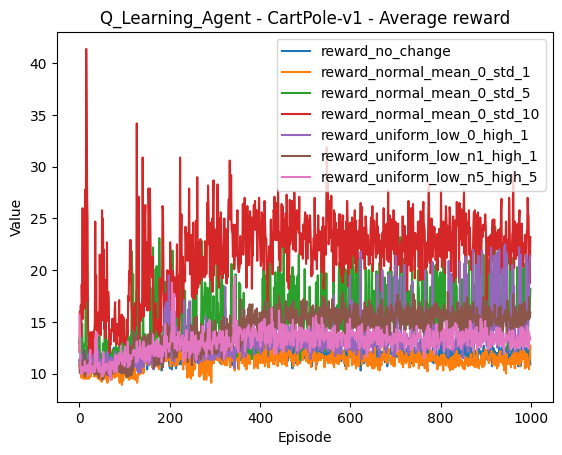

Q_Learning_Agent - CartPole-v1 - Average modified reward final values:
reward_no_change = 10.9
reward_normal_mean_0_std_1 = 11.842824467769502
reward_normal_mean_0_std_5 = 11.542067503912142
reward_normal_mean_0_std_10 = 32.00480247486079
reward_uniform_low_0_high_1 = 32.012153504055846
reward_uniform_low_n1_high_1 = 15.389654073092615
reward_uniform_low_n5_high_5 = 13.145973650555542


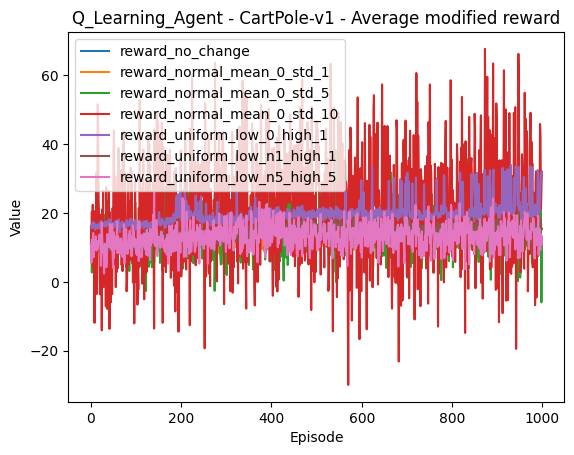

Q_Learning_Agent - CartPole-v1 - Average length final values:
reward_no_change = 10.9
reward_normal_mean_0_std_1 = 12.7
reward_normal_mean_0_std_5 = 18.2
reward_normal_mean_0_std_10 = 23.2
reward_uniform_low_0_high_1 = 21.4
reward_uniform_low_n1_high_1 = 15.9
reward_uniform_low_n5_high_5 = 13.3


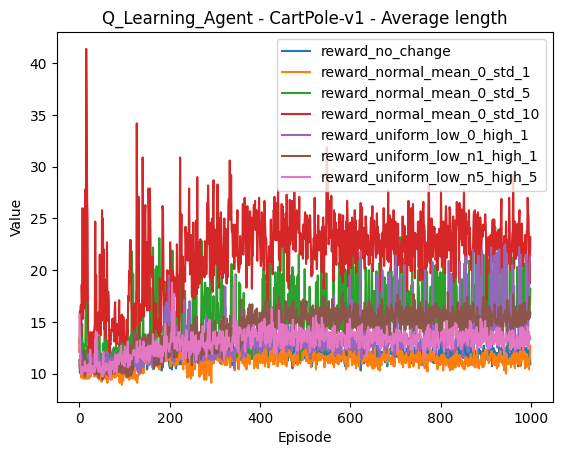

Q_Learning_Agent - CartPole-v1 - Average epsilon values final values:
reward_no_change = 0.002580000000003652
reward_normal_mean_0_std_1 = 0.0030950000000048708
reward_normal_mean_0_std_5 = 0.0012860000000006091
reward_normal_mean_0_std_10 = 0.0010000000000000002
reward_uniform_low_0_high_1 = 0.0023640000000030425
reward_uniform_low_n1_high_1 = 0.0023720000000036524
reward_uniform_low_n5_high_5 = 0.0010000000000000002


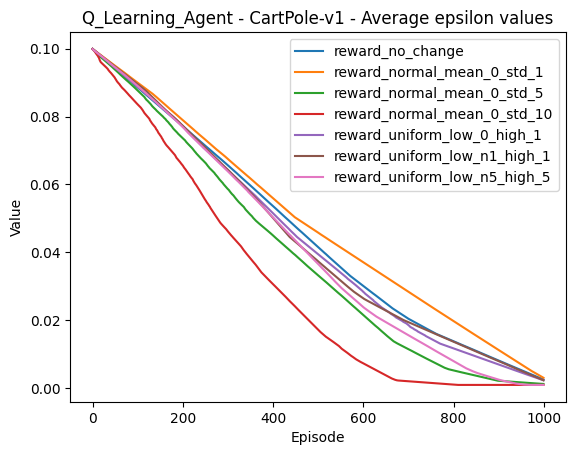

Q_Learning_Agent - Acrobot-v1 - Average reward final values:
reward_no_change = -424.4
reward_normal_mean_0_std_1 = -392.0
reward_normal_mean_0_std_5 = -357.9
reward_normal_mean_0_std_10 = -354.7
reward_uniform_low_0_high_1 = -394.0
reward_uniform_low_n1_high_1 = -405.6
reward_uniform_low_n5_high_5 = -393.8


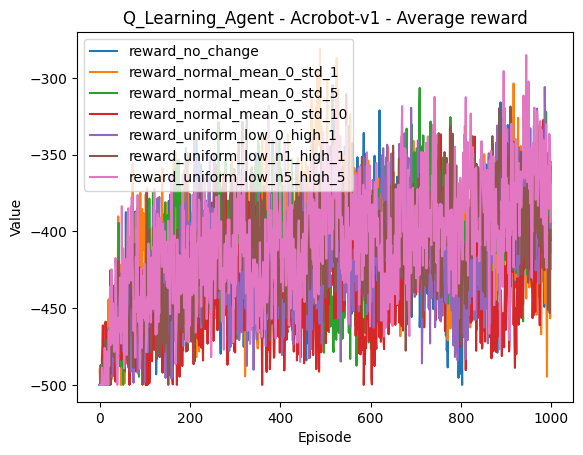

Q_Learning_Agent - Acrobot-v1 - Average modified reward final values:
reward_no_change = -424.4
reward_normal_mean_0_std_1 = -388.90095873688244
reward_normal_mean_0_std_5 = -301.0395907408806
reward_normal_mean_0_std_10 = -338.29513392658527
reward_uniform_low_0_high_1 = -196.73362485181966
reward_uniform_low_n1_high_1 = -404.2017794878717
reward_uniform_low_n5_high_5 = -369.4748279374731


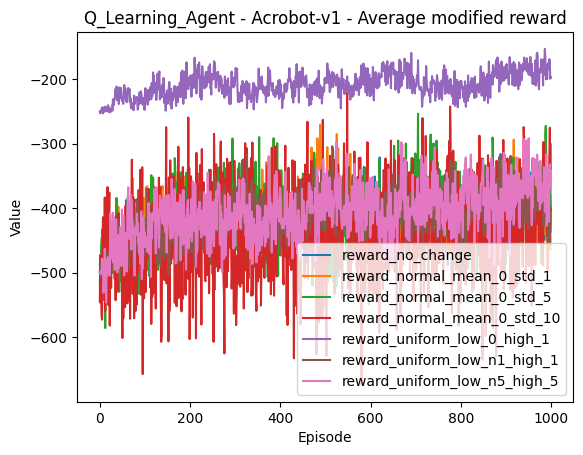

Q_Learning_Agent - Acrobot-v1 - Average length final values:
reward_no_change = 424.7
reward_normal_mean_0_std_1 = 392.6
reward_normal_mean_0_std_5 = 358.6
reward_normal_mean_0_std_10 = 355.5
reward_uniform_low_0_high_1 = 394.6
reward_uniform_low_n1_high_1 = 406.0
reward_uniform_low_n5_high_5 = 394.5


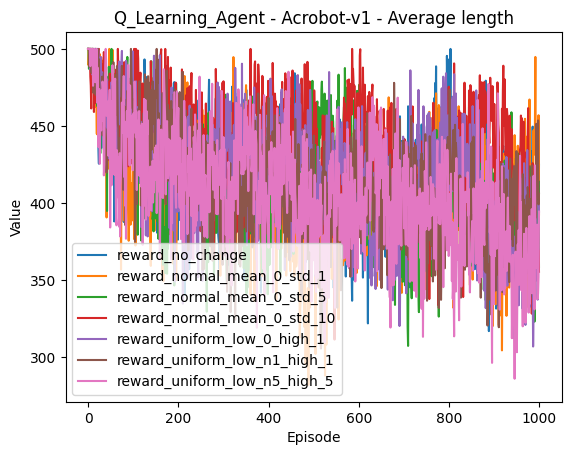

Q_Learning_Agent - Acrobot-v1 - Average epsilon values final values:
reward_no_change = 0.0010000000000000002
reward_normal_mean_0_std_1 = 0.0010000000000000002
reward_normal_mean_0_std_5 = 0.0010000000000000002
reward_normal_mean_0_std_10 = 0.0010000000000000002
reward_uniform_low_0_high_1 = 0.0010000000000000002
reward_uniform_low_n1_high_1 = 0.0010000000000000002
reward_uniform_low_n5_high_5 = 0.0010000000000000002


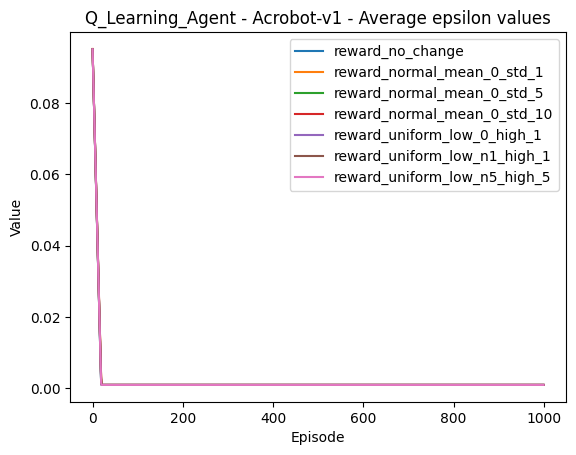

Expected_Sarsa_Agent - CartPole-v1 - Average reward final values:
reward_no_change = 12.7
reward_normal_mean_0_std_1 = 28.0
reward_normal_mean_0_std_5 = 22.9
reward_normal_mean_0_std_10 = 15.4
reward_uniform_low_0_high_1 = 13.3
reward_uniform_low_n1_high_1 = 10.0
reward_uniform_low_n5_high_5 = 17.0


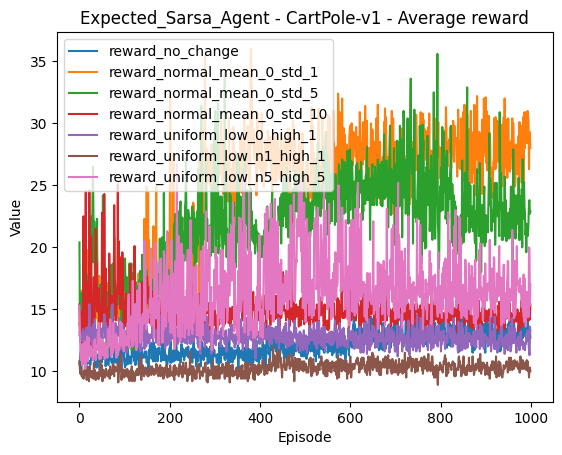

Expected_Sarsa_Agent - CartPole-v1 - Average modified reward final values:
reward_no_change = 12.7
reward_normal_mean_0_std_1 = 30.86989350136495
reward_normal_mean_0_std_5 = 35.360227370797794
reward_normal_mean_0_std_10 = 19.23442703355256
reward_uniform_low_0_high_1 = 20.25947282333746
reward_uniform_low_n1_high_1 = 9.418449493322647
reward_uniform_low_n5_high_5 = 18.288378595203604


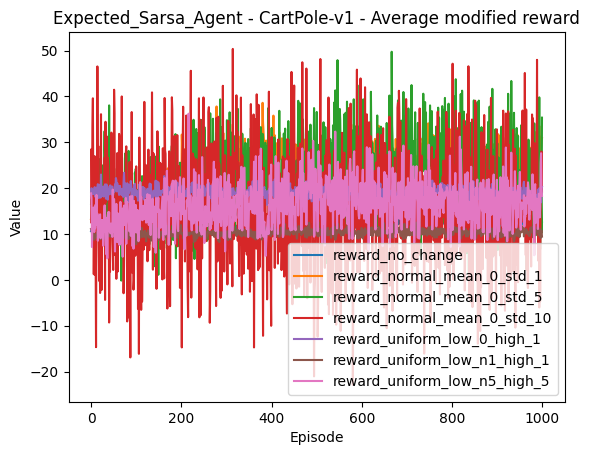

Expected_Sarsa_Agent - CartPole-v1 - Average length final values:
reward_no_change = 12.7
reward_normal_mean_0_std_1 = 28.0
reward_normal_mean_0_std_5 = 22.9
reward_normal_mean_0_std_10 = 15.4
reward_uniform_low_0_high_1 = 13.3
reward_uniform_low_n1_high_1 = 10.0
reward_uniform_low_n5_high_5 = 17.0


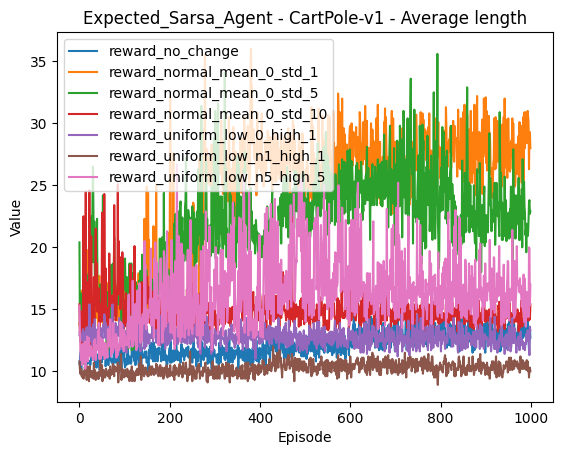

Expected_Sarsa_Agent - CartPole-v1 - Average epsilon values final values:
reward_no_change = 0.002376000000003043
reward_normal_mean_0_std_1 = 0.0017360000000018264
reward_normal_mean_0_std_5 = 0.0010000000000000002
reward_normal_mean_0_std_10 = 0.0010000000000000002
reward_uniform_low_0_high_1 = 0.0018250000000018265
reward_uniform_low_n1_high_1 = 0.002622000000003651
reward_uniform_low_n5_high_5 = 0.0014350000000012176


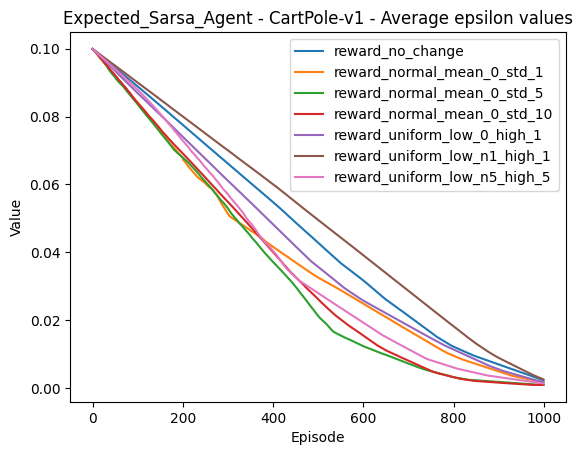

Expected_Sarsa_Agent - Acrobot-v1 - Average reward final values:
reward_no_change = -326.1
reward_normal_mean_0_std_1 = -441.4
reward_normal_mean_0_std_5 = -425.8
reward_normal_mean_0_std_10 = -422.6
reward_uniform_low_0_high_1 = -400.7
reward_uniform_low_n1_high_1 = -334.8
reward_uniform_low_n5_high_5 = -385.3


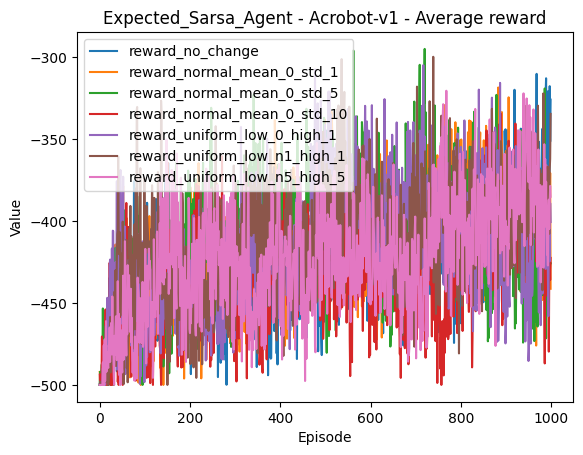

Expected_Sarsa_Agent - Acrobot-v1 - Average modified reward final values:
reward_no_change = -326.1
reward_normal_mean_0_std_1 = -434.26394074653456
reward_normal_mean_0_std_5 = -455.9239468346926
reward_normal_mean_0_std_10 = -483.98823756051553
reward_uniform_low_0_high_1 = -201.2512083996801
reward_uniform_low_n1_high_1 = -328.4750092053703
reward_uniform_low_n5_high_5 = -383.19382933123694


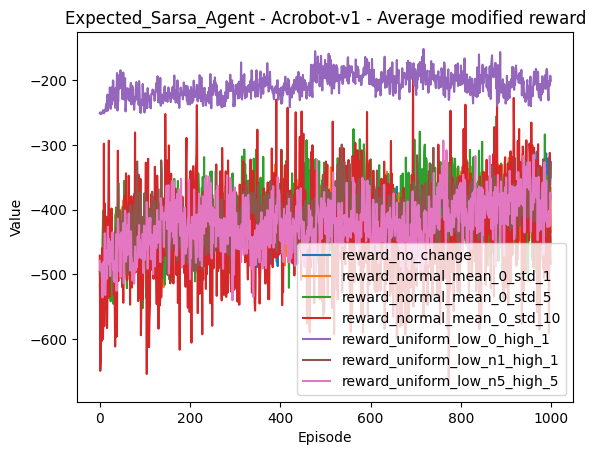

Expected_Sarsa_Agent - Acrobot-v1 - Average length final values:
reward_no_change = 326.9
reward_normal_mean_0_std_1 = 441.7
reward_normal_mean_0_std_5 = 426.3
reward_normal_mean_0_std_10 = 423.3
reward_uniform_low_0_high_1 = 401.2
reward_uniform_low_n1_high_1 = 335.7
reward_uniform_low_n5_high_5 = 385.9


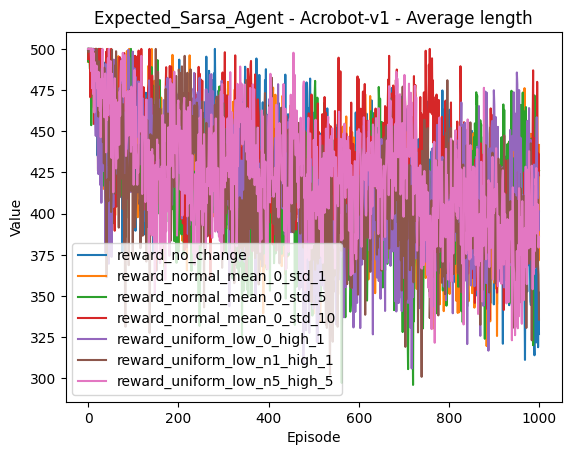

Expected_Sarsa_Agent - Acrobot-v1 - Average epsilon values final values:
reward_no_change = 0.0010000000000000002
reward_normal_mean_0_std_1 = 0.0010000000000000002
reward_normal_mean_0_std_5 = 0.0010000000000000002
reward_normal_mean_0_std_10 = 0.0010000000000000002
reward_uniform_low_0_high_1 = 0.0010000000000000002
reward_uniform_low_n1_high_1 = 0.0010000000000000002
reward_uniform_low_n5_high_5 = 0.0010000000000000002


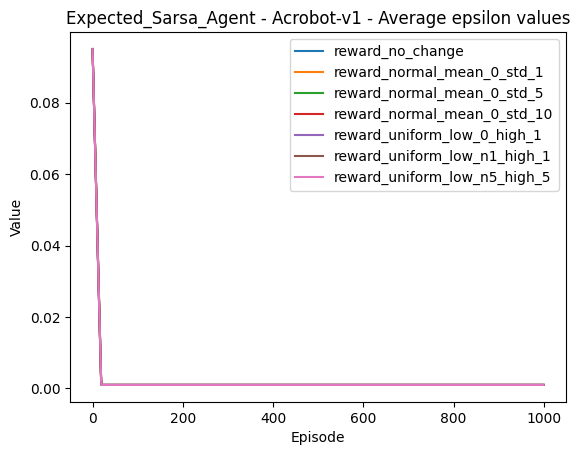

In [127]:
for t_agent in tabular_agents:
  for env, get_action_fn, update_weight_fn, bins in environments_tabular:
    rewards_all = []
    reward_modified_all = []
    length_all = []
    epsilons_all = []

    for reward_fn in reward_functions:
      rewards, reward_modified, length, epsilons = [], [], [], []
      for _ in range(num_of_runs):
          agent = t_agent(env, get_action_fn, update_weight_fn, alpha, bins=bins, num_of_tilings=num_of_tilings, gamma=gamma, epsilon=start_epsilon, eps_min=minimmium_epsilone, eps_dec=epsilone_decrement)
          rewards_, reward_modified_, length_, epsilons_ = test_tabular_agent(agent, env, num_episodes, reward_fn)
          rewards.append(rewards_)
          reward_modified.append(reward_modified_)
          length.append(length_)
          epsilons.append(epsilons_)

      rewards_all.append(rewards)
      reward_modified_all.append(reward_modified)
      length_all.append(length)
      epsilons_all.append(epsilons)

    # Calculate average rewards, reward_modified, length, epsilons
    avg_rewards = np.mean(rewards_all, axis=1)
    avg_reward_modified = np.mean(reward_modified_all, axis=1)
    avg_length = np.mean(length_all, axis=1)
    avg_epsilons = np.mean(epsilons_all, axis=1)

    # Plot all reward functions for this agent and environment
    plt.figure()
    for avg_val, name in [(avg_rewards,"Average reward"),(avg_reward_modified, "Average modified reward"),(avg_length, "Average length"),(avg_epsilons, "Average epsilon values")]:
      print(f'{t_agent.__name__} - {env.spec.id} - {name} final values:')
      for i, reward_fn in enumerate(reward_functions):
          plt.plot(avg_val[i], label=f'{reward_fn.__name__}')
          print(f'{reward_fn.__name__} = {avg_val[i][-1]}')

      plt.title(f'{t_agent.__name__} - {env.spec.id} - {name}')
      plt.xlabel('Episode')
      plt.ylabel('Value')
      plt.legend()
      plt.show()


### run test network

In [128]:
alpha = 0.0001
gamma = 0.99
start_epsilon = 1
memory_size = 5000
minimum_epsilon = 0.1
batch_size = 32
epsilon_decriment = 1e-5

Running Deep_Q_learning_Bach_Agent - CartPole-v1 - reward_no_change...
Running Deep_Q_learning_Bach_Agent - CartPole-v1 - reward_normal_mean_0_std_1...
Running Deep_Q_learning_Bach_Agent - CartPole-v1 - reward_normal_mean_0_std_5...
Running Deep_Q_learning_Bach_Agent - CartPole-v1 - reward_normal_mean_0_std_10...
Running Deep_Q_learning_Bach_Agent - CartPole-v1 - reward_uniform_low_0_high_1...
Running Deep_Q_learning_Bach_Agent - CartPole-v1 - reward_uniform_low_n1_high_1...
Running Deep_Q_learning_Bach_Agent - CartPole-v1 - reward_uniform_low_n5_high_5...
Deep_Q_learning_Bach_Agent - CartPole-v1 - Average reward final values:
reward_no_change = 37.2
reward_normal_mean_0_std_1 = 49.5
reward_normal_mean_0_std_5 = 26.0
reward_normal_mean_0_std_10 = 23.7
reward_uniform_low_0_high_1 = 26.4
reward_uniform_low_n1_high_1 = 34.6
reward_uniform_low_n5_high_5 = 35.2


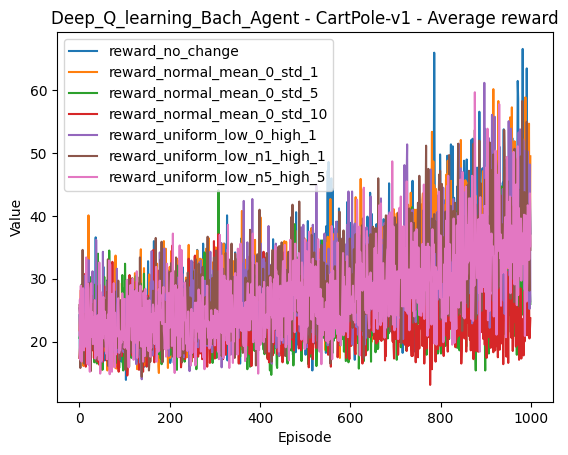

Deep_Q_learning_Bach_Agent - CartPole-v1 - Average modified reward final values:
reward_no_change = 37.2
reward_normal_mean_0_std_1 = 49.62057671518166
reward_normal_mean_0_std_5 = 34.4706801326345
reward_normal_mean_0_std_10 = 37.25927801504699
reward_uniform_low_0_high_1 = 39.215175215661915
reward_uniform_low_n1_high_1 = 35.83376447233225
reward_uniform_low_n5_high_5 = 35.789462206752674


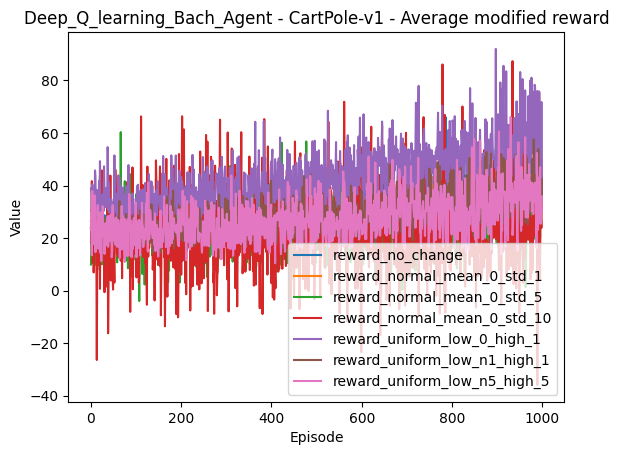

Deep_Q_learning_Bach_Agent - CartPole-v1 - Average length final values:
reward_no_change = 37.2
reward_normal_mean_0_std_1 = 49.5
reward_normal_mean_0_std_5 = 26.0
reward_normal_mean_0_std_10 = 23.7
reward_uniform_low_0_high_1 = 26.4
reward_uniform_low_n1_high_1 = 34.6
reward_uniform_low_n5_high_5 = 35.2


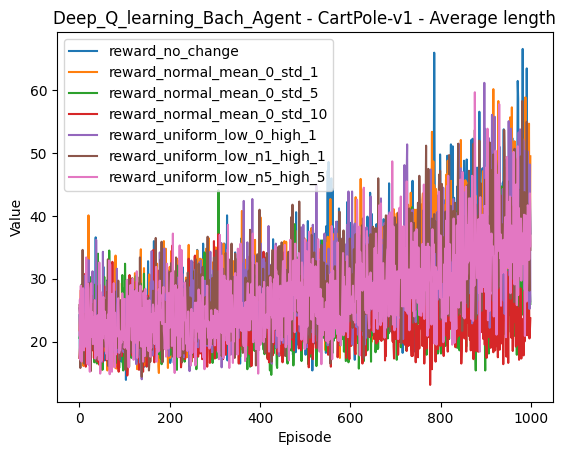

Deep_Q_learning_Bach_Agent - CartPole-v1 - Average epsilon values final values:
reward_no_change = 0.7092190000013232
reward_normal_mean_0_std_1 = 0.7120970000013102
reward_normal_mean_0_std_5 = 0.757224000001105
reward_normal_mean_0_std_10 = 0.7662610000010638
reward_uniform_low_0_high_1 = 0.7096430000013213
reward_uniform_low_n1_high_1 = 0.7117600000013118
reward_uniform_low_n5_high_5 = 0.7289990000012334


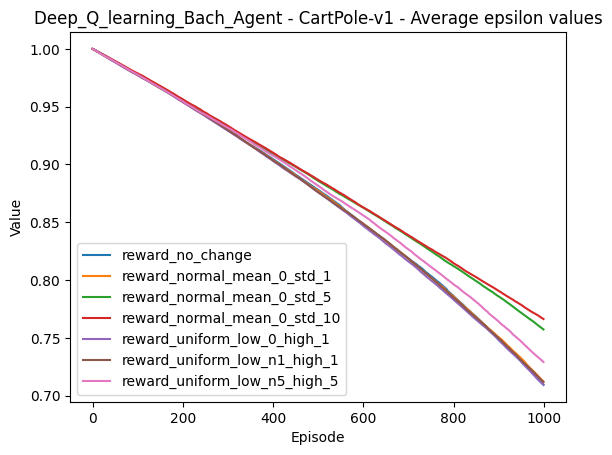

Running Deep_Q_learning_Bach_Agent - Acrobot-v1 - reward_no_change...
Running Deep_Q_learning_Bach_Agent - Acrobot-v1 - reward_normal_mean_0_std_1...
Running Deep_Q_learning_Bach_Agent - Acrobot-v1 - reward_normal_mean_0_std_5...
Running Deep_Q_learning_Bach_Agent - Acrobot-v1 - reward_normal_mean_0_std_10...
Running Deep_Q_learning_Bach_Agent - Acrobot-v1 - reward_uniform_low_0_high_1...
Running Deep_Q_learning_Bach_Agent - Acrobot-v1 - reward_uniform_low_n1_high_1...
Running Deep_Q_learning_Bach_Agent - Acrobot-v1 - reward_uniform_low_n5_high_5...
Deep_Q_learning_Bach_Agent - Acrobot-v1 - Average reward final values:
reward_no_change = -93.5
reward_normal_mean_0_std_1 = -86.3
reward_normal_mean_0_std_5 = -222.5
reward_normal_mean_0_std_10 = -239.2
reward_uniform_low_0_high_1 = -130.5
reward_uniform_low_n1_high_1 = -105.0
reward_uniform_low_n5_high_5 = -143.9


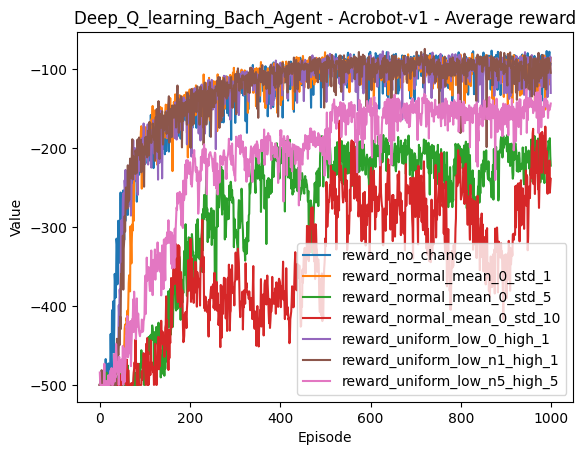

Deep_Q_learning_Bach_Agent - Acrobot-v1 - Average modified reward final values:
reward_no_change = -93.5
reward_normal_mean_0_std_1 = -88.72468590862943
reward_normal_mean_0_std_5 = -243.68057087086177
reward_normal_mean_0_std_10 = -242.1884796654361
reward_uniform_low_0_high_1 = -66.00611107036505
reward_uniform_low_n1_high_1 = -103.5485544154587
reward_uniform_low_n5_high_5 = -133.97694701911118


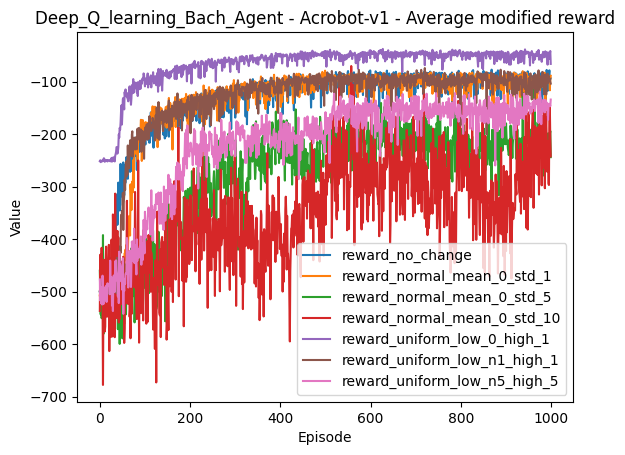

Deep_Q_learning_Bach_Agent - Acrobot-v1 - Average length final values:
reward_no_change = 94.5
reward_normal_mean_0_std_1 = 87.3
reward_normal_mean_0_std_5 = 223.3
reward_normal_mean_0_std_10 = 240.0
reward_uniform_low_0_high_1 = 131.5
reward_uniform_low_n1_high_1 = 106.0
reward_uniform_low_n5_high_5 = 144.8


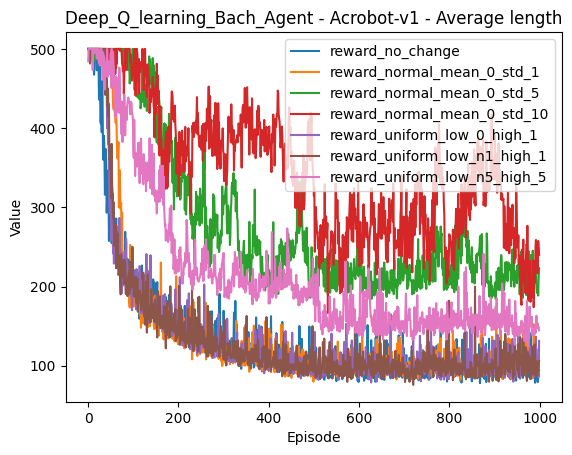

Deep_Q_learning_Bach_Agent - Acrobot-v1 - Average epsilon values final values:
reward_no_change = 0.09999999999999999
reward_normal_mean_0_std_1 = 0.09999999999999999
reward_normal_mean_0_std_5 = 0.09999999999999999
reward_normal_mean_0_std_10 = 0.09999999999999999
reward_uniform_low_0_high_1 = 0.09999999999999999
reward_uniform_low_n1_high_1 = 0.09999999999999999
reward_uniform_low_n5_high_5 = 0.09999999999999999


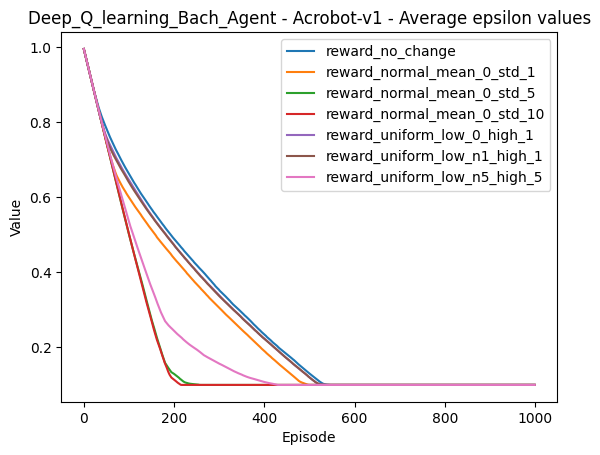

Running DDQ_learning_batch_Agent - CartPole-v1 - reward_no_change...
Running DDQ_learning_batch_Agent - CartPole-v1 - reward_normal_mean_0_std_1...
Running DDQ_learning_batch_Agent - CartPole-v1 - reward_normal_mean_0_std_5...
Running DDQ_learning_batch_Agent - CartPole-v1 - reward_normal_mean_0_std_10...
Running DDQ_learning_batch_Agent - CartPole-v1 - reward_uniform_low_0_high_1...
Running DDQ_learning_batch_Agent - CartPole-v1 - reward_uniform_low_n1_high_1...
Running DDQ_learning_batch_Agent - CartPole-v1 - reward_uniform_low_n5_high_5...
DDQ_learning_batch_Agent - CartPole-v1 - Average reward final values:
reward_no_change = 68.9
reward_normal_mean_0_std_1 = 58.7
reward_normal_mean_0_std_5 = 53.4
reward_normal_mean_0_std_10 = 46.7
reward_uniform_low_0_high_1 = 53.9
reward_uniform_low_n1_high_1 = 39.7
reward_uniform_low_n5_high_5 = 69.7


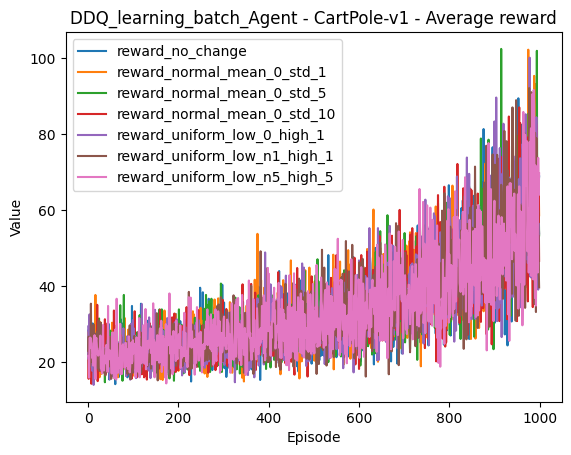

DDQ_learning_batch_Agent - CartPole-v1 - Average modified reward final values:
reward_no_change = 68.9
reward_normal_mean_0_std_1 = 61.30393596919347
reward_normal_mean_0_std_5 = 40.19698334669796
reward_normal_mean_0_std_10 = 15.786996282070401
reward_uniform_low_0_high_1 = 80.74039371182715
reward_uniform_low_n1_high_1 = 40.96910044974554
reward_uniform_low_n5_high_5 = 64.370375242315


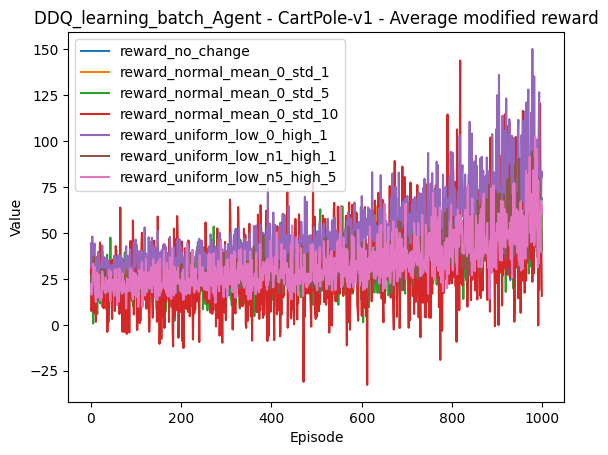

DDQ_learning_batch_Agent - CartPole-v1 - Average length final values:
reward_no_change = 68.9
reward_normal_mean_0_std_1 = 58.7
reward_normal_mean_0_std_5 = 53.4
reward_normal_mean_0_std_10 = 46.7
reward_uniform_low_0_high_1 = 53.9
reward_uniform_low_n1_high_1 = 39.7
reward_uniform_low_n5_high_5 = 69.7


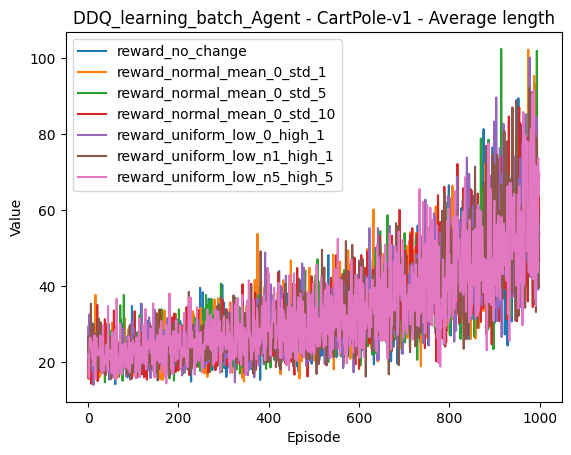

DDQ_learning_batch_Agent - CartPole-v1 - Average epsilon values final values:
reward_no_change = 0.6690530000015062
reward_normal_mean_0_std_1 = 0.6658910000015206
reward_normal_mean_0_std_5 = 0.6646050000015264
reward_normal_mean_0_std_10 = 0.6679770000015111
reward_uniform_low_0_high_1 = 0.6656770000015215
reward_uniform_low_n1_high_1 = 0.6631820000015328
reward_uniform_low_n5_high_5 = 0.666669000001517


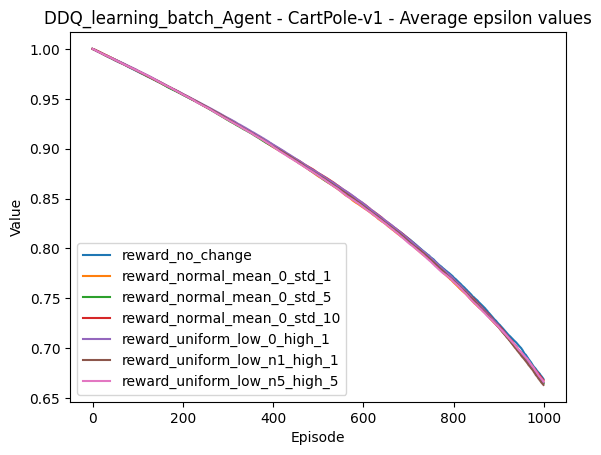

Running DDQ_learning_batch_Agent - Acrobot-v1 - reward_no_change...
Running DDQ_learning_batch_Agent - Acrobot-v1 - reward_normal_mean_0_std_1...
Running DDQ_learning_batch_Agent - Acrobot-v1 - reward_normal_mean_0_std_5...
Running DDQ_learning_batch_Agent - Acrobot-v1 - reward_normal_mean_0_std_10...
Running DDQ_learning_batch_Agent - Acrobot-v1 - reward_uniform_low_0_high_1...
Running DDQ_learning_batch_Agent - Acrobot-v1 - reward_uniform_low_n1_high_1...
Running DDQ_learning_batch_Agent - Acrobot-v1 - reward_uniform_low_n5_high_5...
DDQ_learning_batch_Agent - Acrobot-v1 - Average reward final values:
reward_no_change = -104.3
reward_normal_mean_0_std_1 = -111.1
reward_normal_mean_0_std_5 = -114.0
reward_normal_mean_0_std_10 = -153.9
reward_uniform_low_0_high_1 = -100.9
reward_uniform_low_n1_high_1 = -94.7
reward_uniform_low_n5_high_5 = -109.3


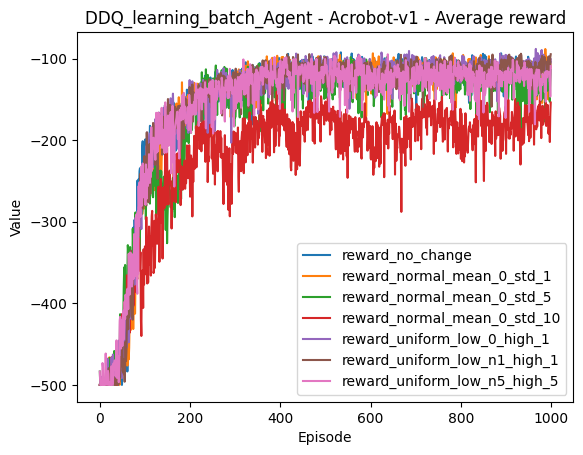

DDQ_learning_batch_Agent - Acrobot-v1 - Average modified reward final values:
reward_no_change = -104.3
reward_normal_mean_0_std_1 = -111.82846562871964
reward_normal_mean_0_std_5 = -129.6835606194229
reward_normal_mean_0_std_10 = -212.82009741203274
reward_uniform_low_0_high_1 = -49.09077963233391
reward_uniform_low_n1_high_1 = -94.62414478800142
reward_uniform_low_n5_high_5 = -98.5559800439523


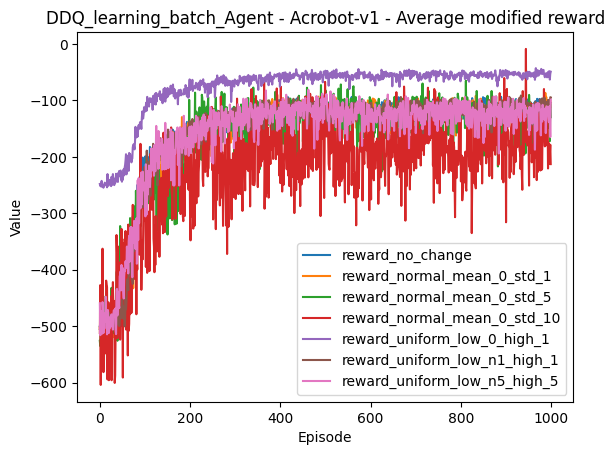

DDQ_learning_batch_Agent - Acrobot-v1 - Average length final values:
reward_no_change = 105.3
reward_normal_mean_0_std_1 = 112.1
reward_normal_mean_0_std_5 = 115.0
reward_normal_mean_0_std_10 = 154.8
reward_uniform_low_0_high_1 = 101.9
reward_uniform_low_n1_high_1 = 95.7
reward_uniform_low_n5_high_5 = 110.3


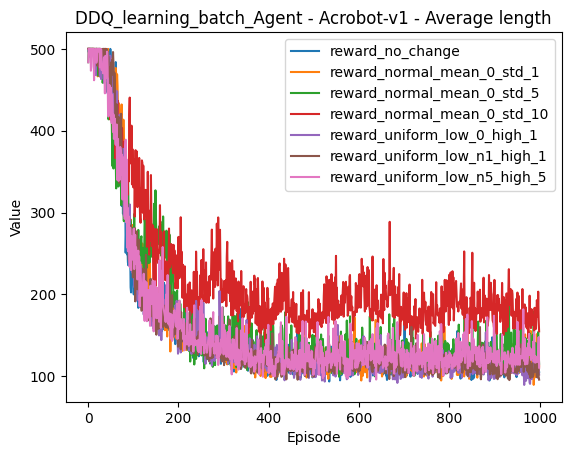

DDQ_learning_batch_Agent - Acrobot-v1 - Average epsilon values final values:
reward_no_change = 0.09999999999999999
reward_normal_mean_0_std_1 = 0.09999999999999999
reward_normal_mean_0_std_5 = 0.09999999999999999
reward_normal_mean_0_std_10 = 0.09999999999999999
reward_uniform_low_0_high_1 = 0.09999999999999999
reward_uniform_low_n1_high_1 = 0.09999999999999999
reward_uniform_low_n5_high_5 = 0.09999999999999999


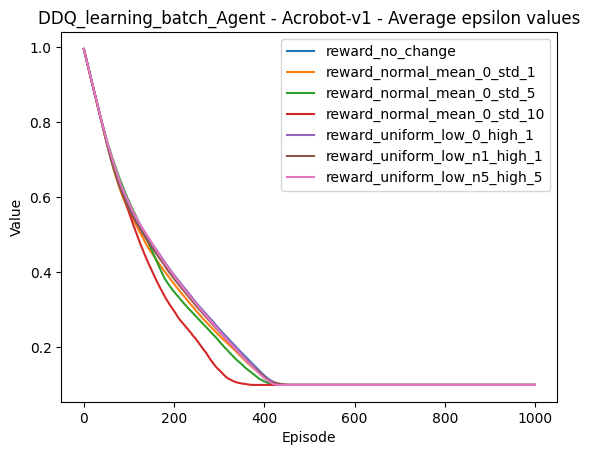

In [131]:
for n_agent in network_agents:
  for env in environments_network:
    rewards_all = []
    reward_modified_all = []
    length_all = []
    epsilons_all = []

    for reward_fn in reward_functions:
      print(f'Running {n_agent.__name__} - {env.spec.id} - {reward_fn.__name__}...')
      rewards, reward_modified, length, epsilons = [], [], [], []
      for _ in range(num_of_runs):
        agent = n_agent(env.observation_space.shape, env.action_space.n, alpha, gamma=gamma, epsilon=start_epsilon, mem_size=memory_size, eps_min=minimum_epsilon, batch_size=batch_size, eps_dec=epsilon_decriment)
        rewards_, reward_modified_, length_, epsilons_ = test_Deep_agent(agent, env, num_episodes, reward_fn)
        rewards.append(rewards_)
        reward_modified.append(reward_modified_)
        length.append(length_)
        epsilons.append(epsilons_)

      rewards_all.append(rewards)
      reward_modified_all.append(reward_modified)
      length_all.append(length)
      epsilons_all.append(epsilons)

    # Calculate average rewards, reward_modified, length, epsilons
    avg_rewards = np.mean(rewards_all, axis=1)
    avg_reward_modified = np.mean(reward_modified_all, axis=1)
    avg_length = np.mean(length_all, axis=1)
    avg_epsilons = np.mean(epsilons_all, axis=1)

    # Plot all reward functions for this agent and environment
    plt.figure()
    for avg_val, name in [(avg_rewards,"Average reward"),(avg_reward_modified, "Average modified reward"),(avg_length, "Average length"),(avg_epsilons, "Average epsilon values")]:
      print(f'{n_agent.__name__} - {env.spec.id} - {name} final values:')
      for i, reward_fn in enumerate(reward_functions):
          plt.plot(avg_val[i], label=f'{reward_fn.__name__}')
          print(f'{reward_fn.__name__} = {avg_val[i][-1]}')

      plt.title(f'{n_agent.__name__} - {env.spec.id} - {name}')
      plt.xlabel('Episode')
      plt.ylabel('Value')
      plt.legend()
      plt.show()
